In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from wordcloud import WordCloud
from collections import Counter

In [2]:
class FakeNewsDetector:
    def __init__(self, true_data_path, fake_data_path, num_words=5000, maxlen=200, epochs=10, batch_size=128):
        self.true_data_path = true_data_path
        self.fake_data_path = fake_data_path
        self.num_words = num_words
        self.maxlen = maxlen
        self.epochs = epochs
        self.batch_size = batch_size
        self.tokenizer = Tokenizer(num_words=self.num_words)
        self.model = self.build_model()

    def load_data(self):
        # Load the cleaned datasets
        true_data = pd.read_csv(self.true_data_path)
        fake_data = pd.read_csv(self.fake_data_path)

        # Add a label column to distinguish between true and fake news
        true_data['label'] = 1
        fake_data['label'] = 0

        # Combine the datasets
        data = pd.concat([true_data, fake_data], ignore_index=True)

        # Shuffle the data
        data = data.sample(frac=1).reset_index(drop=True)

        return true_data, fake_data, data

    def preprocess_data(self, data):
        # Tokenization
        self.tokenizer.fit_on_texts(data['Content'])
        X = self.tokenizer.texts_to_sequences(data['Content'])
        X = pad_sequences(X, maxlen=self.maxlen)
        y = to_categorical(data['label'])

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self):
        model = Sequential()
        model.add(Embedding(input_dim=self.num_words, output_dim=128, input_length=self.maxlen))
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.5))
        model.add(LSTM(32))
        model.add(Dropout(0.5))
        model.add(Dense(2, activation='softmax', dtype='float32'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def train_model(self, X_train, y_train):
        history = self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2)
        return history

    def evaluate_model(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        print(f'Accuracy: {accuracy}')

        conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        print(classification_report(y_test_classes, y_pred_classes))

    def visualize_word_importance(self):
        # Get the weights from the embedding layer
        embedding_layer = self.model.layers[0]
        weights = embedding_layer.get_weights()

        if weights and len(weights) > 0:
            weights = weights[0]
        else:
            raise ValueError("Embedding layer weights are not available.")

        # Get the word index from the tokenizer
        word_index = self.tokenizer.word_index

        # Create a DataFrame for plotting
        word_importance = pd.DataFrame({
            'Word': [word for word, idx in word_index.items() if idx < weights.shape[0]],
            'Importance': [np.linalg.norm(weights[idx]) for word, idx in word_index.items() if idx < weights.shape[0]]
        })

        # Sort by importance
        word_importance = word_importance.sort_values(by='Importance', ascending=False)

        # Top 10 words by importance
        top_words = word_importance.head(10)

        # Bar chart for top words by importance
        plt.figure(figsize=(10, 5))
        sns.barplot(x='Importance', y='Word', data=top_words)
        plt.title('Top 10 Words by Importance in the Embedding Layer')
        plt.xlabel('Importance')
        plt.ylabel('Word')
        plt.show()

    def visualize_word_clouds(self, true_data, fake_data):
        # Word cloud for true news
        true_text = ' '.join(true_data['Content'])
        wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_true, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for True News')
        plt.show()

        # Word cloud for fake news
        fake_text = ' '.join(fake_data['Content'])
        wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_fake, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Fake News')
        plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 213ms/step - accuracy: 0.8833 - loss: 0.2870 - val_accuracy: 0.9848 - val_loss: 0.0584
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - accuracy: 0.9904 - loss: 0.0359 - val_accuracy: 0.9867 - val_loss: 0.0474
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.9922 - loss: 0.0264 - val_accuracy: 0.9863 - val_loss: 0.0503
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - accuracy: 0.9927 - loss: 0.0240 - val_accuracy: 0.9893 - val_loss: 0.0378
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - accuracy: 0.9970 - loss: 0.0108 - val_accuracy: 0.9895 - val_loss: 0.0378
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9888 - val_loss: 0.0610
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - accuracy: 0.9987 - loss: 0.0040 - val_accuracy: 0.9887 - val_loss: 0.0502
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 214ms/step - accuracy: 0.9985 - loss: 0

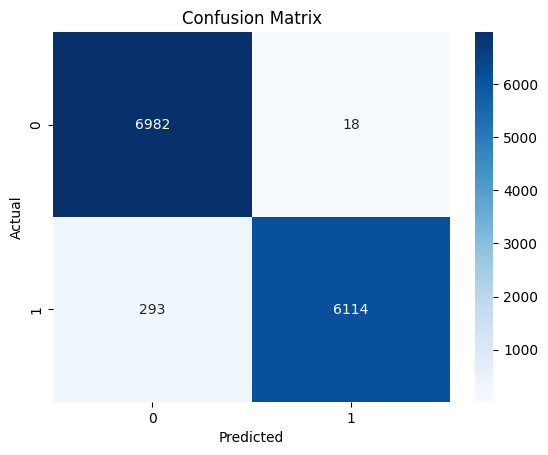

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7000
           1       1.00      0.95      0.98      6407

    accuracy                           0.98     13407
   macro avg       0.98      0.98      0.98     13407
weighted avg       0.98      0.98      0.98     13407



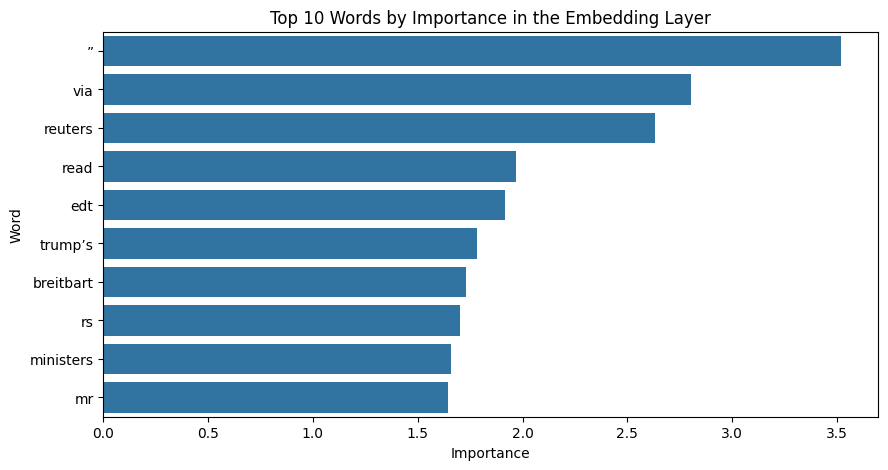

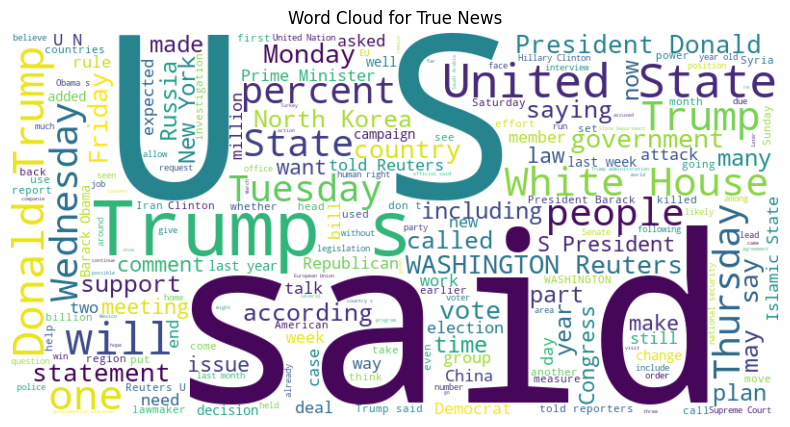

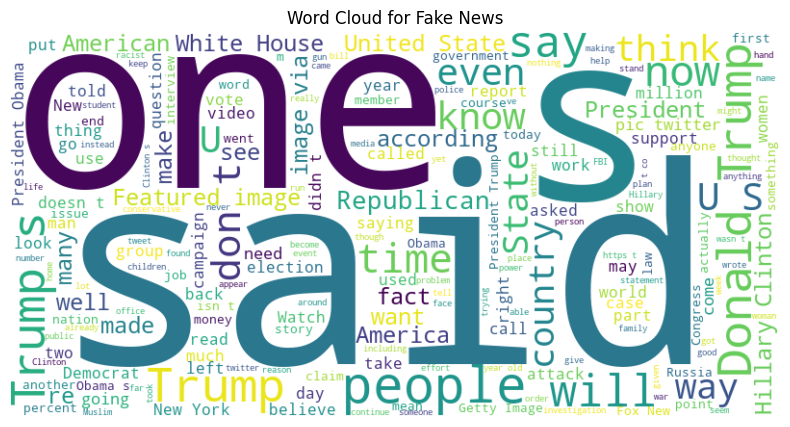

In [3]:
# Create an instance of the FakeNewsDetector class
detector = FakeNewsDetector(true_data_path='Cleaned_True_Data.csv', fake_data_path='Cleaned_False_Data.csv')

# Load and preprocess the data
true_data, fake_data, data = detector.load_data()
X_train, X_test, y_train, y_test = detector.preprocess_data(data)

# Train the model
history = detector.train_model(X_train, y_train)

# Evaluate the model
detector.evaluate_model(X_test, y_test)

# Visualize word importance
detector.visualize_word_importance()

# Visualize word clouds
detector.visualize_word_clouds(true_data, fake_data)